<font size="+3"><strong> Project 2: Data Wrangling</strong></font>

## Table of Contents
<ul>
<li><a href="#Gathering">1.0 Gathering Data</a></li>
<li><a href="#Accessing">2.0 Accessing Data</a></li>
<li><a href="#Cleaning">3.0 Cleaning Data</a></li>
<li><a href="#Storing">4.0 Storing Data</a></li>
<li><a href="#Eda">5.0 Analyzing and Visualizing Data</a></li>
</ul>

## Import packages
The first step of any data analysis project is importing the packages

In [1]:
import requests
import json
from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt 
import tweepy
from tweepy import OAuthHandler

<a id='Gathering'></a>
## 1.0 Gathering Data
Import "*twitter-archive-enhanced.csv*" into the workspace

In [2]:
df_archive = pd.read_csv("twitter-archive-enhanced.csv")

Create access tokens with my twitter developer authetication passcodes

In [ ]:
consumer_key = "CONSUMER KEY"
consumer_secret = "CONSUMER SECRET"
access_token = "ACCESS TOKEN"
access_secret = "ACCESS SECRET"

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [ ]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

Query Twitter's API for JSON data for each tweet ID in **df_archive** and appending Exceptions to *fails_dict*


In [ ]:
count = 0
fails_dict = {}
start = timer()

with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except Exception as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

Next

Import *'tweet_json.txt'* into a pandas DataFrame *df_api*

In [3]:
df_api = pd.read_json("tweet_json.txt",lines=True)

Create *image_predictions.tsv* Programmatically from the Udacity server

In [4]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

In [5]:
with open("image_predictions.tsv","wb") as file:
    file.write(response.content)

Import "*image_predictions.tsv*" into pandas DataFrame

In [6]:
df_img_pred= pd.read_csv("image_predictions.tsv",sep="\t")

Now we have gathered the **3** different DataFrames we need for this Project, It is time to access them for quality and tidiness

<a id='Accessing'></a>
## 2.0 Accessing Data
### 2.1 Data Quality
 - Visual assessment

In [ ]:
df_archive

In [ ]:
df_api

In [ ]:
df_img_pred

Now let us access our data programmatically
- Programmatic Assesment

In [ ]:
type(df_archive.timestamp[0])

In [ ]:
df_archive.floofer.value_counts()

In [ ]:
df_archive[df_archive.name== 'None']

In [ ]:
df_archive.info()

In [ ]:
df_api.possibly_sensitive_appealable.value_counts()

### 2.2 Data Tidiness

In [84]:
df_archive.text.head(1).tolist()

["This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"]

In [11]:
df_api[["id","id_str"]].sample()

,id,id_str
536,803692223237865472,803692223237865472


<a id='Cleaning'></a>
## 3.0 Cleaning Data
### 3.1 Clean df_api
First I will make a copy of *df_api* called *df_api_clean*

In [7]:
df_api_clean = df_api.copy()

The first step of cleaning *df_api_clean* is to drop redundant columns i.e columns with over 70% NAN values

In [8]:
#list of redundant cols
nan_columns = ["in_reply_to_status_id","in_reply_to_status_id_str","in_reply_to_user_id","in_reply_to_user_id_str",
         "in_reply_to_screen_name","geo","coordinates","place","contributors","retweeted_status","quoted_status_id",
         "quoted_status_id_str","quoted_status_permalink","quoted_status"]

In [9]:
#Drop nan_columns from df_api_clean
df_api_clean.drop(columns=nan_columns,inplace=True)

In [59]:
#Test
for col in nan_columns:
    if col in df_api_clean.columns:
        print("Error!!")

The next step to cleaning *df_api_clean* is dropping single cardinality variables that do not offer any information to us

In [11]:
# Identify single cardinality columns i.e columns with only one value 
# and append to our single_val_cols list
single_val_cols =[]
for col in df_api_clean.columns:
    if len(df_api_clean[col].value_counts()) == 1:
        single_val_cols.append(col)
        print(col)
    else:
         pass

truncated
favorited
retweeted
possibly_sensitive
possibly_sensitive_appealable


In [12]:
# Drop single_val_cols from df_api_clean
df_api_clean.drop(columns= single_val_cols,inplace=True)

In [13]:
#Test
for col in single_val_cols:
    if col in df_api_clean.columns:
        print("Error!!!")

During Visual assessment, I found that the "*id*" column is duplicated in *id_str* so we drop *id_str* column and rename *id* to *tweet_id*

In [14]:
# Drop id_str col
df_api_clean.drop(columns="id_str",inplace=True)

In [15]:
# Rename "id" to "tweet_id" and "created_at" to "timestamp"
df_api_clean.rename(columns= {"id":"tweet_id",
                             "created_at":"timestamp"},
                    inplace=True)

Columns *entities, user* and *extended_entities* contain data we have in other columns/tables and appear to be very noisy, so lets drop them

In [16]:
df_api_clean.drop(columns=["extended_entities","user","entities"],inplace=True)

In [17]:
#Test
for col in ["extended_entities","user","entities"]:
    if col in df_api_clean.columns:
        print("Error!!!")

During Data Tidiness Assessment we found that column *full_text* contains the ratings and the tweet link alongside the tweet,we want to extract all three into different columns using **Regular Expression**

To do that, let us define a function *extract_multi_cols*

In [18]:
def extract_multi_cols (df,text_col,url_col,rate_col):
    """Takes in four parameters df, text_col, url_col, rate_col and returns 
    df with additional two new column
    
        Parameters:
            df : DataFrame containing the data
            text_col(str): name of column in df to extract new cols from
            url_col(str) : name of column to contain the tweet url
            rate_col(str): name of column to contain the tweet ratings
        Returns:
            df : DataFrame containing cleaned with two new columns
    """
    #Extract the url_col and drop it from the text_col 
    df[url_col] = df[text_col].str.extract("(?P<url>https?://[^\s]+)",expand=True)
    df[text_col] = df[text_col].str.replace("\s*(?P<url>https?://[^\s]+)\s*","",n=1,regex=True)
    
    #Extract the rate_col and drop it from the text_col
    df[rate_col] = df[text_col].str.extract("([0-9]{1,2}/[0-9]{1,2})",expand=True)
    df[text_col] = df[text_col].str.replace("([0-9]{1,2}/[0-9]{1,2})","",n=1,regex=True)
    
    return df
    

Now let us use our function **extract_multi_cols** to solve our tidiness issues in *df_api_clean*

In [19]:
df_api_clean = extract_multi_cols(df_api_clean,"full_text","tweet_url","ratings")

In [20]:
#Test
df_api_clean[["tweet_url","ratings"]].head()

,tweet_url,ratings
0,https://t.co/MgUWQ76dJU,13/10
1,https://t.co/0Xxu71qeIV,13/10
2,https://t.co/wUnZnhtVJB,12/10
3,https://t.co/tD36da7qLQ,13/10
4,https://t.co/AtUZn91f7f,12/10


### 3.2 Clean df_archive
First I will make a copy of *df_archive* called *df_archive_clean*

In [21]:
df_archive_clean = df_archive.copy()

Again, The first step of cleaning *df_api_clean* is to drop redundant columns i.e columns with over 70% NAN values

In [22]:
#list of redundact columns
redundact_list = ["in_reply_to_status_id","in_reply_to_user_id","retweeted_status_id",
                 "retweeted_status_user_id","retweeted_status_timestamp",]

In [23]:
# Drop redundact columns
df_archive_clean.drop(columns=redundact_list,inplace=True)

In [24]:
#Test
for col in redundact_list:
    if col in df_img_pred.columns:
        print("Error!!!")

Convert column *timestamp* to a pandas Datetime object

In [25]:
df_archive_clean.timestamp = pd.to_datetime(df_archive_clean.timestamp)

In [26]:
#Test
df_archive_clean.timestamp.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2356 entries, 0 to 2355
Series name: timestamp
Non-Null Count  Dtype              
--------------  -----              
2356 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 18.5 KB


Rename column *text* to *full_text*

In [27]:
df_archive_clean.rename(columns={"text":"full_text"},inplace=True)

Now lets use our *extract_multi_cols* function to solve the same tidiness issues we saw while cleaning df_api

In [28]:
df_archive_clean = extract_multi_cols(df_archive_clean,"full_text","tweet_url","ratings")

### 3.3 Clean df_img_pred
First I will make a copy of *df_img_pred* called *df_pred_clean*

In [29]:
df_pred_clean = df_img_pred.copy()

Our *df_pred_clean* table looks pretty clean but we need to do some cleaning

I will convert the dog breed names in columns *p1, p2* and *p3* to lowercase

In [30]:
dog_breed = ["p1","p2","p3"]
for col in dog_breed:
    df_pred_clean[col]= df_pred_clean[col].str.lower()

In [31]:
#Test
df_pred_clean[["p1","p2","p3"]].head()

,p1,p2,p3
0,welsh_springer_spaniel,collie,shetland_sheepdog
1,redbone,miniature_pinscher,rhodesian_ridgeback
2,german_shepherd,malinois,bloodhound
3,rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,rottweiler,doberman


<a id='Storing'></a>
## 4.0 Storing Data

Now it is time to combine our three cleaned Dataframes and store it as a csv file ***twitter_archive_master.csv***

In [32]:
# Combine df_api_clean, df_archive_clean and df_pred_clean
master_df = pd.merge(pd.merge(df_api_clean,
                                df_archive_clean,on=['tweet_id',"timestamp","source","tweet_url","ratings","full_text"]),
                       df_pred_clean,on='tweet_id')

In [33]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           2057 non-null   datetime64[ns, UTC]
 1   tweet_id            2057 non-null   int64              
 2   full_text           2057 non-null   object             
 3   display_text_range  2057 non-null   object             
 4   source              2057 non-null   object             
 5   is_quote_status     2057 non-null   bool               
 6   retweet_count       2057 non-null   int64              
 7   favorite_count      2057 non-null   int64              
 8   lang                2057 non-null   object             
 9   tweet_url           2057 non-null   object             
 10  ratings             2057 non-null   object             
 11  expanded_urls       2057 non-null   object             
 12  rating_numerator    2057 non-null 

In [34]:
# Store master_df as csv file
master_df.to_csv("twitter_archive_master.csv",index=False)

<a id='Eda'></a>
## 5.0 Analyzing and Visualizing Data

Now we want to use our *master_df* to get some insights into our data

### 5.1 Question 1: What are the names of the top 10 dogs with the highest retweet count and their ratings?

First, let us create a DataFrame with the top 10 dog names as index and their *rating_numerator* and *retweet_count* as the columns 

In [35]:
# Create top_ten_dogs DataFrame 
top_ten_dogs = pd.pivot_table(
    master_df,index="name",
    values = ["retweet_count","rating_numerator"],
    aggfunc='max'
    
).sort_values(by="retweet_count",ascending=False).head(10)

In [36]:
top_ten_dogs

,rating_numerator,retweet_count
name,,
None,420,70380
Stephan,13,51455
Duddles,13,37291
Bo,14,34438
Jamesy,13,30074
Kenneth,10,27666
quite,12,26186
Buddy,13,25030
Zoey,13,22669


We can see the **ratings** and **names** of the top 10 retweeted dogs but the first dog does not seem to conform to the defined schema for "*rating_numerator*" so we drop the row  

In [37]:
#Drop dirty row from top_ten_dogs
top_ten_dogs.drop(["None"],axis=0,inplace=True)
top_ten_dogs

,rating_numerator,retweet_count
name,,
Stephan,13,51455
Duddles,13,37291
Bo,14,34438
Jamesy,13,30074
Kenneth,10,27666
quite,12,26186
Buddy,13,25030
Zoey,13,22669
Sunny,14,17734


Let us visualize it

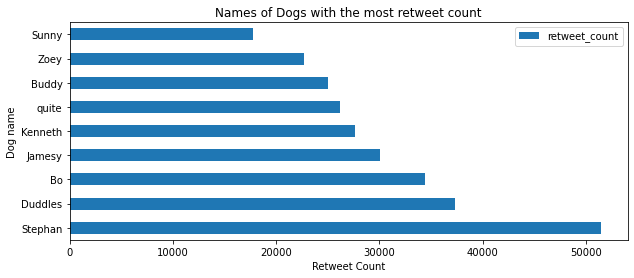

In [38]:
# Plot dog names to retweet count
fig,ax = plt.subplots(figsize=(10,4))
top_ten_dogs.drop(columns="rating_numerator").plot.barh(ax=ax)
plt.ylabel("Dog name")
plt.xlabel("Retweet Count")
plt.title("Names of Dogs with the most retweet count");

### 5.2 Questionn 2 : What is the average *Retweet_counts* by rating of the dogs in our top_ten_dogs DataFrame?

In [39]:
top_ten_dogs.groupby("rating_numerator")["retweet_count"].mean().sort_values(ascending=False).to_frame()

,retweet_count
rating_numerator,
13,33303.8
10,27666.0
12,26186.0
14,26086.0


We can see that the dogs rated **13** and **10** recorded the highest average retweet count whilst **14** had the lowest average rating among the dogs in *top_ten_dogs* 

### 5.3 Question 3: What is the Proportion of each dog rating in our Dataset and which rating appeared more frequently?

First, Let us see the unique *rating_numerator*values in our **master_df** DataFrame

In [40]:
unique_rates = master_df.rating_numerator.unique().tolist()
len(unique_rates)

35

We can see that we have a lot of unique dog ratings (35) but from the [data schema](https://knowyourmeme.com/memes/theyre-good-dogs-brent), we can see that the range of dog ratings should be from **10 to 15**, so anything above and below does not conform to this defined schema

To perform our analysis let us extract the ratings that are not valid

In [41]:
# Extract invalid ratings and append to invalid_list
invalid_rate_list=[]
valid_rate_list= []
for idx in unique_rates:
    if idx not in range(10,16,1):
        invalid_rate_list.append(idx)
    else:
        valid_rate_list.append(idx)

Using DataFrame **.mask()** method, let us convert invalid *rating_numerator* to **NaN** and then drop it from the df

In [42]:
master_df.mask((master_df.rating_numerator < 10) | (master_df.rating_numerator > 15),inplace=True)

In [43]:
#Drop NaN and convert back to type int
master_df.dropna(inplace=True)
master_df.rating_numerator = master_df[["rating_numerator"]].astype(int)

Now we have drop Invalid data, we can now check the proportion of each rating to the entire ratings in our *master_df* DataFrame

In [44]:
# Check the Value Count of Rating
master_df.rating_numerator.value_counts().to_frame()

,rating_numerator
12,471
10,425
11,413
13,275
14,38
15,1


We can see that in our Entire dataset, only one dog received a **15** rating, and well over 471 dogs recieved **12** rating

Let check the proportion of this ratings

In [45]:
master_df.rating_numerator.value_counts(normalize=True).to_frame()

,rating_numerator
12,0.290203
10,0.261861
11,0.254467
13,0.169439
14,0.023413
15,0.000616


With **471** Dogs rated as 12 that represents about **29%** of our Dataset 

In [47]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 0 to 2051
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           1623 non-null   datetime64[ns, UTC]
 1   tweet_id            1623 non-null   float64            
 2   full_text           1623 non-null   object             
 3   display_text_range  1623 non-null   object             
 4   source              1623 non-null   object             
 5   is_quote_status     1623 non-null   object             
 6   retweet_count       1623 non-null   float64            
 7   favorite_count      1623 non-null   float64            
 8   lang                1623 non-null   object             
 9   tweet_url           1623 non-null   object             
 10  ratings             1623 non-null   object             
 11  expanded_urls       1623 non-null   object             
 12  rating_numerator    1623 non-null 

During the Cleaning process of our previous analysis, some columns in our *master_df* DataFrame had there datatypes changed
Let us convert back to the appropriate Datatypes

In [49]:
#List of cols to convert
integer_cols = ["tweet_id","retweet_count","favorite_count","rating_denominator","img_num"]
bool_cols = ["is_quote_status","p1_dog","p2_dog","p3_dog"]

In [76]:
#convert interger_cols and bool_cols to dtypes int and bool respectively
master_df[integer_cols] = master_df[integer_cols].astype(int)
master_df[bool_cols] = master_df[bool_cols].astype(bool)
master_df["tweet_id"] = master_df["tweet_id"].apply(abs)

In [77]:
master_df.tweet_id.head()

0    2147483648
1    2147483648
2    2147483648
3    2147483648
4    2147483648
Name: tweet_id, dtype: int64